Выбор региона анализа

In [133]:
region = 'АЛМ'

Импорт библиотек

In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline
plt.style.use('seaborn')

C:\Users\killr\AppData\Local\Temp\ipykernel_14536\3352321590.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# ASIA STOCKS

Загрузка данных

In [135]:
Sales = pd.read_excel('data\Загрузка продажи '+region+'.xlsx')
Stocks = pd.read_excel('data\Остатки загрузка '+region+'.xlsx')
Nomen = pd.read_excel('data\Загрузка справочник '+region+'.xlsx')
Comming = pd.read_excel('data\В пути '+region+'.xlsx')

In [136]:
Comming = Comming[['Артикул','Кон ост']]
Comming = Comming.rename({'Артикул':'АРТИКУЛ', 'Кон ост':'В пути'}, axis=1)

In [137]:

Sales = Sales.rename({'Дата':'ДАТА', 'Артикул':'АРТИКУЛ', 'Менеджер':'МЕНЕДЖЕР','Клиент':'КЛИЕНТ','Продажа ШТ':'ПРОДАЖА ШТ'}, axis=1)
Sales = Sales.fillna(0)

Stocks = Stocks.rename({'Дата':'ДАТА', 'Артикул':'АРТИКУЛ', 'Цена':'ЦЕНА','Кон ост':'ОСТАТОК','Расход':'РАСХОД'}, axis=1)
Stocks = Stocks.drop(['Склад','Есть общие обороты за день','Номенклатура'], axis=1)
#Stocks = Stocks.fillna(0)
#Stocks['ОСТАТОК'] = Stocks['ОСТАТОК'].apply(lambda x: np.nan if x==0 else x)

Nomen = Nomen.rename({'Артикул':'АРТИКУЛ', 'Товар':'ТОВАР','Ед изм':'ЕД ИЗМ','Прямой':'ПРЯМОЙ', 
                      'Статус номенклатуры':'СТАТУС','Номенклатура.Объем (знаменатель)':'Кор','Номенклатура.Объем (числитель)':'Объем',
                      'Поставщик':'ПОСТАВЩИК','Активность':'АКТИВНОСТЬ' }, axis=1)

Nomen['В пути'] = Nomen['АРТИКУЛ'].apply(lambda x: 0 if Comming[Comming['АРТИКУЛ']==x].shape[0] == 0 else Comming[Comming['АРТИКУЛ']==x]['В пути'].iloc[0])
Nomen = Nomen.fillna(0)

*Проверим дубликаты прямой и НВС и объединим их в один артикул*

In [138]:
multi_df = Nomen.groupby(['ТОВАР','ЕД ИЗМ','ПОСТАВЩИК'])['АРТИКУЛ'].unique().reset_index()
multi_df['len'] = multi_df['АРТИКУЛ'].apply(len)
art_groups = list(multi_df[multi_df['len']>1]['АРТИКУЛ'].values)

arts_to_delete = list()
d_art_head = dict()
for item in art_groups:
    for art in item:
        l = list(item.copy())
        l.pop(0)
        d_art_head[art] = [item[0], l]
        arts_to_delete.extend(l)

arts_to_delete = list(set(arts_to_delete))

Sales['АРТИКУЛ'] = Sales['АРТИКУЛ'].apply(lambda x: x if x not in list(d_art_head.keys()) else d_art_head[x][0])
Stocks['АРТИКУЛ'] = Stocks['АРТИКУЛ'].apply(lambda x: x if x not in list(d_art_head.keys()) else d_art_head[x][0])
Nomen['ДУБЛИКАТЫ'] = Nomen['АРТИКУЛ'].apply(lambda x: '' if x not in list(d_art_head.keys()) else d_art_head[x][1])

Nomen.index = Nomen['АРТИКУЛ']
Nomen = Nomen.drop(arts_to_delete,axis=0).drop('АРТИКУЛ',axis=1)
Nomen = Nomen.reset_index()


*Сделаем преодразования даты и вычислим параметр медианных недельных продаж*

In [139]:
#Sales['ДАТА'] = Sales['ДАТА'].apply(lambda x: x[:-3])
#Sales['ДАТА'] = pd.to_datetime(Sales['ДАТА'], format='%d.%m.%Y')

In [140]:
#Sales['НЕДЕЛЯ'] = Sales['ДАТА'].dt.dayofyear // 7

Sales['ДАТА'] = pd.to_datetime(Sales['ДАТА'], format='%d.%m.%Y')
Sales['ДАТА_число'] = Sales['ДАТА'].dt.dayofyear
min_date = Sales['ДАТА_число'].min()
Sales['ДАТА_число'] = Sales['ДАТА_число'] - min_date
Sales['НЕДЕЛЯ'] = Sales['ДАТА_число'] // 7

week_sales = pd.pivot_table(data = Sales, columns='АРТИКУЛ',index='НЕДЕЛЯ', values='ПРОДАЖА ШТ', aggfunc='sum')
week_sales = week_sales.fillna(0)
week_sales = week_sales.median()

In [141]:
Stocks['ДАТА'] = Stocks['ДАТА'].apply(lambda x: x[:-8])

In [142]:
Stocks['ДАТА'] = pd.to_datetime(Stocks['ДАТА'] , format='%d.%m.%Y')

Создадим таблицу по параметрам артикулов и добавим в нее параметры, связанные с клиентами и статистикой продаж

In [143]:
Nomen['ПОСТАВЩИК'] = Nomen['ПОСТАВЩИК'].apply(lambda x: x[:15])
Nomen['АГ'] = Nomen['АГ'].apply(lambda x: str(x)[:20])

*Число клиентов*

In [144]:
table = Sales.groupby('АРТИКУЛ')['КЛИЕНТ'].nunique()

In [145]:
Client_count = list(Nomen['АРТИКУЛ'].unique())
Client_count = pd.DataFrame(Client_count, columns=['АРТИКУЛ'])
Client_count['Count'] = Client_count['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.index) else table[x])
Client_count.index = Client_count['АРТИКУЛ']
Client_count = Client_count.drop('АРТИКУЛ', axis=1)

In [146]:
piv_nom = Nomen.copy()
piv_nom['КЛИЕНТОВ'] = piv_nom['АРТИКУЛ'].apply(lambda x: Client_count.loc[x])

In [147]:
piv_nom['week_sales_median'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(week_sales.index) else week_sales.loc[x])

*Доля самого крупного клиента*

In [148]:
table = Sales.groupby(['АРТИКУЛ', 'КЛИЕНТ'])['ПРОДАЖА ШТ'].sum().reset_index().sort_values(by=['АРТИКУЛ','ПРОДАЖА ШТ'], ascending=False)
table2 = Sales.groupby(['АРТИКУЛ'])['ПРОДАЖА ШТ'].sum().sort_values(ascending=False).reset_index()
table = pd.merge(left=table, right=table2, on='АРТИКУЛ', how='left')
table['ДОЛЯ'] = table['ПРОДАЖА ШТ_x'] / table['ПРОДАЖА ШТ_y']
table = table.groupby('АРТИКУЛ')['ДОЛЯ'].max()
piv_nom['ДОЛЯ МАКС КЛИЕНТА'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.index) else table.loc[x])
piv_nom.head(2)

,АРТИКУЛ,ТОВАР,ЕД ИЗМ,ПРЯМОЙ,ПОСТАВЩИК,АКТИВНОСТЬ,АГ,НГ,СТАТУС,Кор,Объем,В пути,ДУБЛИКАТЫ,КЛИЕНТОВ,week_sales_median,ДОЛЯ МАКС КЛИЕНТА
0,102136,"Форма для фуршетов 20 мл 120х38х28 мм ""Buffet""...",упак,Нет,ВЗЛП ООО,Да,Формы для фуршетов и,Формы для фуршетов квадратные и проч. до 25 мл,Вывод,20.0,0.019,0,,0,0.0,0.0
1,102138,"Чашка кофейная 75 мл ""Buffet"", черн., ПС, 12 ш...",упак,Нет,ВЗЛП ООО,Да,"Стаканы, чашки, крыш",Чашки кофейные до 180 мл,Вывод,20.0,0.009,0,,0,0.0,0.0


*Загрузка средней цены за период*

In [149]:
table = Stocks.groupby('АРТИКУЛ')['ЦЕНА'].median()
piv_nom['ЦЕНА'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.index) else table.loc[x])

*Вычисление стат параметров стока и продаж*

In [150]:
table = pd.pivot_table(Stocks,values='ОСТАТОК',aggfunc='sum',columns='АРТИКУЛ', index='ДАТА').sort_index()
table = table.replace(to_replace=0., value=np.nan)
stock_nulls = table.isnull().mean()
table = table.fillna(0)

In [151]:
piv_nom = pd.merge(left=piv_nom, right=table.describe().T.reset_index()[['АРТИКУЛ','mean','std','max','50%']], on='АРТИКУЛ', how='left')
piv_nom = piv_nom.rename({'mean':'stocks_mean','std':'stocks_std', 'max':'stocks_max','50%':'stocks_median'}, axis=1)

In [152]:
curr_stock = table.iloc[-1:].T
piv_nom['curr_stock'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(curr_stock.index) else curr_stock.loc[x].values[0]) 

In [153]:
table2 = pd.pivot_table(Sales,values='ПРОДАЖА ШТ',aggfunc='sum',columns='АРТИКУЛ', index='ДАТА').sort_index()
sales_nulls = table2.isnull().mean()
table2 = table2.fillna(0)



In [154]:
piv_nom = pd.merge(left=piv_nom, right=table2.describe().T.reset_index()[['АРТИКУЛ','mean','std','max','50%']], on='АРТИКУЛ', how='left')
piv_nom = piv_nom.rename({'mean':'sales_mean','std':'sales_std', 'max':'sales_max','50%':'sales_median'}, axis=1)

In [155]:
piv_nom = piv_nom.fillna(0)

*Добавим признаки % дней без продаж и без остатков*

In [156]:
piv_nom['sales_nulls'] = piv_nom['АРТИКУЛ'].apply(lambda x: 1 if x not in list(sales_nulls.index) else sales_nulls[x])
piv_nom['stock_nulls'] = piv_nom['АРТИКУЛ'].apply(lambda x: 1 if x not in list(stock_nulls.index) else stock_nulls[x])

*Добавим признак симметрии. Рассчитаем его как ковариацию вектора последовательных продаж с вектором линейного роста от минимума к максимуму*

In [157]:
def calc_sym_coef(art, table):
    min_val = table[art].min()
    max_val = table[art].max()
    v = np.linspace(min_val,max_val,table.shape[0])
    w = table[art].values
    v = v - v.mean()
    v = v / np.linalg.norm(v)
    w = w - w.mean()
    if np.linalg.norm(w)<0.0001:
        return 0
    w = w /np.linalg.norm(w)
    return v@w

In [158]:
piv_nom['stock_sym'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.columns) else calc_sym_coef(x,table))
piv_nom['sales_sym'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table2.columns) else calc_sym_coef(x,table2))

*Создадим признаки в деньгах*

In [159]:
stat_features_units = ['stocks_mean','stocks_std','stocks_max','stocks_median',
                    'sales_mean', 'sales_std', 'sales_max','sales_median','curr_stock','week_sales_median']

for feature in stat_features_units:
    piv_nom[feature+'_$'] = piv_nom[feature] * piv_nom['ЦЕНА']

*Посмотрим на распределения созданных признаков и решим, что их этого логарифмировать*

In [160]:
features = ['sales_nulls', 'stock_nulls', 'stock_sym', 'sales_sym',
       'stocks_mean_$', 'stocks_std_$', 'stocks_max_$', 'stocks_median_$',
       'sales_mean_$', 'sales_std_$', 'sales_max_$', 'sales_median_$','КЛИЕНТОВ', 'ДОЛЯ МАКС КЛИЕНТА','week_sales_median_$']
#
#fig, axes = plt.subplots(len(features)//2+1,2, figsize = [10,15])
#for i,feature in enumerate(features):
#    sns.histplot(piv_nom[feature], ax= axes[i//2][i%2])
#    axes[i//2][i%2].set_ylabel(feature)

In [161]:
features_to_log = ['stocks_mean_$', 'stocks_std_$', 'stocks_max_$', 'stocks_median_$',
       'sales_mean_$', 'sales_std_$', 'sales_max_$', 'sales_median_$','КЛИЕНТОВ','week_sales_median_$']

for feature in features_to_log:
    piv_nom[feature+'_log'] = piv_nom[feature].apply(lambda x: 0 if (x+1)<=0 else np.log(x+1))

In [162]:
features = ['stocks_mean_$_log', 'stocks_std_$_log', 'stocks_max_$_log',
       'stocks_median_$_log', 'sales_mean_$_log', 'sales_std_$_log',
       'sales_max_$_log', 'sales_median_$_log', 'КЛИЕНТОВ_log','week_sales_median_$_log']

#fig, axes = plt.subplots(len(features)//2+1,2, figsize = [10,10])
#for i,feature in enumerate(features):
#    sns.histplot(piv_nom[feature], ax= axes[i//2][i%2])
#    axes[i//2][i%2].set_ylabel(feature)

***Отбор признаков для кластеризации***

In [163]:
features = ['sales_nulls', 'stock_nulls', 'stock_sym', 'sales_sym',
       'stocks_mean_$_log', 'stocks_max_$_log', 'sales_mean_$_log','sales_median_$_log', 'КЛИЕНТОВ_log','week_sales_median_$_log']

clust_data = piv_nom[features]

#sns.heatmap(clust_data.corr(), annot=True, fmt='.2f')

In [164]:
#clust_data.isnull().sum()

*Нормализуем данные*

In [165]:

scaler = MinMaxScaler()
clust_data = scaler.fit_transform(clust_data)

*Попробуем кластеризировать данные*

In [166]:
from sklearn.cluster import AgglomerativeClustering

params = list()
for i in range(3,10):
    agc = AgglomerativeClustering(n_clusters=i)
    clusters = agc.fit_predict(clust_data)
    params.append([i,silhouette_score(clust_data,clusters)])
    
params = pd.DataFrame(params, columns=['K','silhouette'])
params.sort_values('silhouette', ascending=False)

,K,silhouette
6,9,0.386628
5,8,0.379879
4,7,0.368584
3,6,0.354157
2,5,0.350068
1,4,0.343885
0,3,0.311178


In [167]:
agc = AgglomerativeClustering(n_clusters=9)
agc.fit(clust_data)
#display(pd.Series(agc.labels_).value_counts().sort_values(ascending=False)/pd.Series(agc.labels_).value_counts().sum()*100)

agc_df = pd.DataFrame(clust_data, columns=features)
agc_df['cluster'] = agc.labels_
piv_nom['cluster'] = agc.labels_
#agc_df = agc_df[(agc_df['cluster'] != 0) & (agc_df['cluster'] != 6)& (agc_df['cluster'] != 2)
#                & (agc_df['cluster'] != 5)& (agc_df['cluster'] != 8)& (agc_df['cluster'] != 7)& (agc_df['cluster'] != 4)]
#sns.heatmap(agc_df.groupby('cluster').mean(), annot=True, fmt='.3f', cmap='Reds')


После анализа результатов было создано решающее правило, которое помогло универсально подойти у 2м филиалам (ну и к любоиу количеству складов в будующем). Вся суть ML здесь в том, что оно помогло подобрать "хорошие" правила для категоризации товаров.
Также пришлось признак недельной медианы для верного определения регулярных товаров

*Присвоение имен кластеров*

In [168]:
def set_cluster_name(art):
    df = scaler.transform(piv_nom[piv_nom['АРТИКУЛ'] == art][features])
    df = pd.DataFrame(df, columns=features)
    if df['sales_median_$_log'].iloc[0] > 0:
        return 'Ядерные'
    elif df['week_sales_median_$_log'].iloc[0] > 0:
        return 'Регулярные'
    elif (df['sales_mean_$_log'].iloc[0] == 0) & (df['stock_nulls'].iloc[0] == 0):
        return 'Висяки'
    elif (df['sales_mean_$_log'].iloc[0] == 0) & (df['КЛИЕНТОВ_log'].iloc[0] == 0) & (df['stock_sym'].iloc[0] < 0.33):
        return 'Висяки'
    elif (df['sales_mean_$_log'].iloc[0] == 0) & (df['КЛИЕНТОВ_log'].iloc[0] == 0) & (df['stock_sym'].iloc[0] > 0.66):
        return 'Плохие новинки'
    elif (df['stock_nulls'].iloc[0] < 0.35) & (df['sales_mean_$_log'].iloc[0] > 0):
        return 'Опасные'
    elif (df['stock_sym'].iloc[0] > 0.57)& (df['sales_mean_$_log'].iloc[0] > 0):
        return 'Хорошие новинки'
    else:
        return 'Под заказ'

piv_nom['cluster_name'] = piv_nom['АРТИКУЛ'].apply(set_cluster_name)


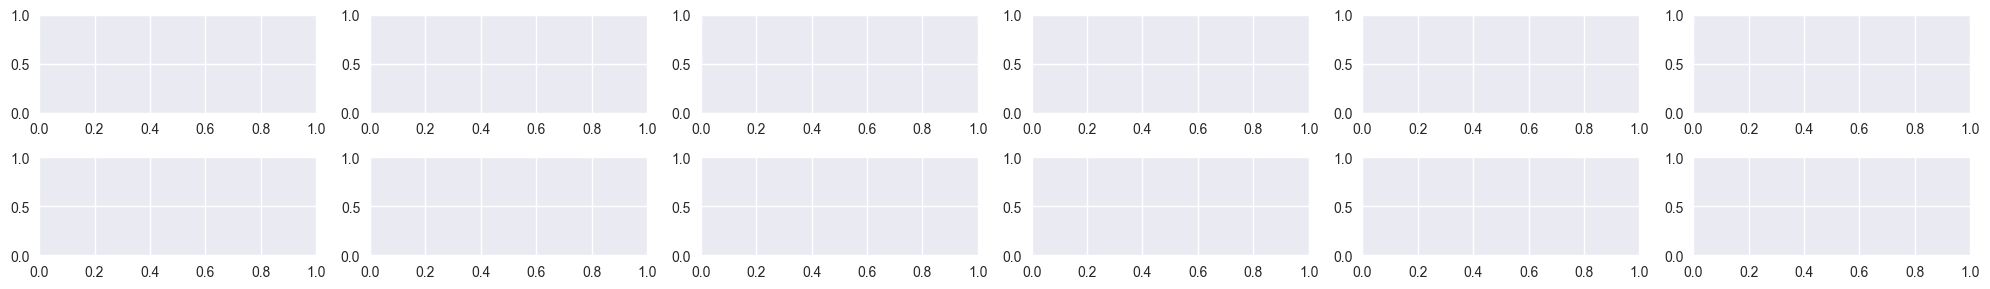

In [169]:

cluster = list(piv_nom[( piv_nom['cluster_name']==' ')]['АРТИКУЛ'])

fig, axes = plt.subplots(len(cluster)//6+2,6, figsize = [20,len(cluster)//6*2+3])
for i,art in enumerate(cluster):
    if art in list(table.columns):
        sns.lineplot(table[art].T, ax=axes[i//6][i%6])
    if art in list(table2.columns):    
        sns.lineplot(table2[art].T, ax=axes[i//6][i%6])
    axes[i//6][i%6].set_xlabel(' ')
    axes[i//6][i%6].set_ylabel(' ')
    axes[i//6][i%6].set_title('Арт '+str(art)+' Дин прод:'+str(piv_nom[piv_nom['АРТИКУЛ']==art]['sales_sym'].iloc[0].round(2)))
     
plt.tight_layout()

Вычисление дефицитов. Считаем их только для кластеров: Регулярный, Ядерный, Хорошие новинки, Опасные

*Вычистление границы уровня дефицита*

In [170]:
def set_deficit_level(art):
    cluster = piv_nom[piv_nom['АРТИКУЛ'] == art]['cluster_name'].iloc[0]
    if cluster in ['Регулярные','Ядерные','Хорошие новинки']:
        reserch_table = table2[art].T
        reserch_table = reserch_table[reserch_table>0]
        q25 = np.quantile(reserch_table,q=0.25)
        q75 = np.quantile(reserch_table,q=0.75)
        qtr = q75-q25
        deficit_level = q75+1.5*qtr
        if deficit_level > reserch_table.max():
            return reserch_table.max()
        else:
            return deficit_level
    else:
        return 0

In [171]:
piv_nom['deficit_level'] = piv_nom['АРТИКУЛ'].apply(set_deficit_level)
#piv_nom['deficit_level'] = piv_nom['sales_mean']+3*piv_nom['sales_std'] #Это Эвристика конечно
#piv_nom['deficit_level'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if piv_nom[piv_nom['АРТИКУЛ']==x]['cluster_name'].iloc[0] == 'Под заказ' else x)
piv_nom['curr_deficit'] = piv_nom['deficit_level'] - piv_nom['curr_stock']
piv_nom['curr_deficit'] = piv_nom['curr_deficit'].apply(lambda x: x if x>0 else 0)
piv_nom['curr_deficit_$'] = piv_nom['curr_deficit']*piv_nom['ЦЕНА']

*Вычисление неликвидов*

In [172]:
piv_nom['overstock_level'] = piv_nom['sales_mean']*33+piv_nom['deficit_level']
piv_nom['curr_overstok'] = piv_nom['curr_stock'] - piv_nom['overstock_level']
piv_nom['curr_overstok'] = piv_nom['curr_overstok'].apply(lambda x: x if x>0 else 0)
piv_nom['curr_overstok_$'] = piv_nom['curr_overstok']*piv_nom['ЦЕНА']

*Формирование зон стока: дефицит, риск дефицита, оптимум, излишек, неликвид*

In [173]:
piv_nom['risk_zone_level'] = piv_nom['deficit_level'] + (piv_nom['sales_mean'])*5
piv_nom['optimum_zone_level'] = piv_nom['deficit_level'] + (piv_nom['overstock_level'] - piv_nom['deficit_level'])*(2/3)
piv_nom['risk_zone_level_$'] = piv_nom['risk_zone_level']*piv_nom['ЦЕНА']
piv_nom['optimum_zone_level_$'] = piv_nom['optimum_zone_level']*piv_nom['ЦЕНА']

In [174]:
def set_stock_zone(art):
    curr_stock = piv_nom[piv_nom['АРТИКУЛ'] == art]['curr_stock'].iloc[0]
    deficit_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['deficit_level'].iloc[0]
    risk_zone_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['risk_zone_level'].iloc[0]
    optimum_zone_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['optimum_zone_level'].iloc[0]
    overstock_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['overstock_level'].iloc[0]
    
    if curr_stock > overstock_level:
        return 'Неликвид'
    elif curr_stock > optimum_zone_level:
        return 'Излишек'
    elif curr_stock > risk_zone_level:
        return 'Оптимум'
    elif curr_stock > deficit_level:
        return 'Риск дефицита'
    else:
        if piv_nom[piv_nom['АРТИКУЛ'] == art]['cluster_name'].iloc[0] in ['Под заказ','Опасные','Плохие новинки','Висяки']:
            return 'Плохие группы без остатка'
        else:    
            return 'Дефицит'
        
piv_nom['stock_zone'] = piv_nom['АРТИКУЛ'].apply(set_stock_zone)

Расчет общих показателей

In [175]:
#Число товаров по кластерам
cluster_artnum = piv_nom.groupby('cluster_name')['АРТИКУЛ'].nunique()

if 'Ядерные' not in list(cluster_artnum.index):
    cluster_artnum['Ядерные'] = 0

#Число товаров по типам стока
stockzone_artnum = piv_nom.groupby('stock_zone')['АРТИКУЛ'].nunique()
#Общая оборачиваемость
table4 = Stocks.copy()
table4['ОСТАТОК_$'] = table4['ОСТАТОК']* table4['ЦЕНА']
mean_stock = table4.groupby('ДАТА')['ОСТАТОК_$'].sum().mean()
mean_sales = piv_nom['sales_mean_$'].sum()
turnover = mean_stock/mean_sales*7/5
#Клиентов на артикул
mean_clints_by_art = piv_nom.groupby('АРТИКУЛ')['КЛИЕНТОВ'].sum().mean()
#Сумма дефицита по Регулярному, Ядерному, Хорошим новинкам
deficit_sum = 0
for feature in ['Ядерные', 'Регулярные','Хорошие новинки']:
    deficit_sum += piv_nom[piv_nom['cluster_name'] == feature]['curr_deficit_$'].sum()
#Сумма неликвида по Висякам, Опасным, Плохим новинкам, Под заказ
overstock_sum = 0
for feature in ['Висяки', 'Плохие новинки','Под заказ', 'Опасные']:
    overstock_sum += piv_nom[piv_nom['cluster_name'] == feature]['curr_overstok_$'].sum()    

#Индекс эффективности товарного запаса
stocks_eff_index = (stockzone_artnum.loc['Оптимум'] + stockzone_artnum.loc['Излишек'] + stockzone_artnum.loc['Риск дефицита'])/(stockzone_artnum.sum()-stockzone_artnum.loc['Плохие группы без остатка'])*100
#Индекс эффективности ассортиментной матрицы
v = np.linspace(0,1,7)
v = v - v.mean()
v = v/np.linalg.norm(v)
w = np.array([cluster_artnum.loc['Висяки'],cluster_artnum.loc['Плохие новинки'],cluster_artnum.loc['Опасные'],cluster_artnum.loc['Под заказ'],cluster_artnum.loc['Хорошие новинки'],cluster_artnum.loc['Регулярные'],cluster_artnum.loc['Ядерные']]).astype('float')
w = w - w.mean()
w = w/np.linalg.norm(w)
atrmatrix_eff_index = (v@w /2 + 1/2)*100
#
params = pd.DataFrame([turnover, deficit_sum/1000000, overstock_sum/1000000, mean_clints_by_art,stocks_eff_index,atrmatrix_eff_index], index=['Оборачиваемость кд','Дефицит млн тенге','Неликвид млн тенге','Клиентов на артикул','Эффективность запасов','Эффективность ассортимента'])

In [176]:
table4 = pd.read_excel('Динамика '+str(region)+'.xlsx', index_col=0)
if str(table4.index.max()) !=  str(Stocks['ДАТА'].dt.date.max()):
    table5 = pd.concat([cluster_artnum, stockzone_artnum, params], axis=0).rename({0:str(Stocks['ДАТА'].dt.date.max())},axis=1).T
    table4 = pd.concat([table4, table5], axis=0)

table4.to_excel('Динамика '+str(region)+'.xlsx')


Расчет выгрузок в Эксель

In [177]:
#Хорошие группы в дефиците
table5 = piv_nom[(piv_nom['cluster_name'] == 'Ядерные') | 
        (piv_nom['cluster_name'] == 'Регулярные') | 
        (piv_nom['cluster_name'] == 'Хорошие новинки')]
table5 = table5[table5['curr_deficit_$'] > 0].sort_values(by='curr_deficit_$', ascending=False)
table5 = table5[['АРТИКУЛ', 'ТОВАР', 'ПРЯМОЙ', 'ПОСТАВЩИК', 'АКТИВНОСТЬ', 'АГ', 'НГ',
       'КЛИЕНТОВ', 'ДОЛЯ МАКС КЛИЕНТА', 'ЦЕНА', 'cluster_name', 'curr_deficit', 'curr_deficit_$',
       'stock_zone']]
table5.to_excel('output\Дефициты '+str(region)+' '+ str(Stocks['ДАТА'].dt.date.max()) +'.xlsx')

#Плохие группы в неликвиде ['Висяки', 'Плохие новинки','Под заказ', 'Опасные']
table5 = piv_nom.copy()#[(piv_nom['cluster_name'] == 'Висяки') | 
        #(piv_nom['cluster_name'] == 'Плохие новинки') | 
        #(piv_nom['cluster_name'] == 'Под заказ') |
        #(piv_nom['cluster_name'] == 'Опасные')]
table5 = table5[table5['curr_overstok_$'] > 0].sort_values(by='curr_overstok_$', ascending=False)
table5 = table5[['АРТИКУЛ', 'ТОВАР', 'ПРЯМОЙ', 'ПОСТАВЩИК', 'АКТИВНОСТЬ', 'АГ', 'НГ',
       'КЛИЕНТОВ', 'ДОЛЯ МАКС КЛИЕНТА', 'ЦЕНА', 'cluster_name', 'curr_overstok', 'curr_overstok_$',
       'stock_zone']]
table5.to_excel('output\Неликвиды '+str(region)+' '+ str(Stocks['ДАТА'].dt.date.max()) +'.xlsx')

#Ядерные
#piv_nom[piv_nom['cluster_name'] == 'Ядерные'][['АРТИКУЛ', 'ТОВАР', 'ПРЯМОЙ', 'ПОСТАВЩИК', 'АКТИВНОСТЬ', 'АГ', 'НГ',
#       'КЛИЕНТОВ', 'ДОЛЯ МАКС КЛИЕНТА', 'ЦЕНА', 'cluster_name']].to_excel('output\Ядерные '+str(region)+' '+ str(Stocks['ДАТА'].dt.date.max()) +'.xlsx')

#Без движения
#piv_nom[(piv_nom['cluster_name'] == 'Висяки') & (piv_nom['curr_overstok_$']>0)][['АРТИКУЛ', 'ТОВАР', 'ПРЯМОЙ', 'ПОСТАВЩИК', 'АКТИВНОСТЬ', 'АГ', 'НГ',
#       'КЛИЕНТОВ', 'ДОЛЯ МАКС КЛИЕНТА', 'ЦЕНА', 'cluster_name','curr_overstok_$','curr_overstok']].to_excel('output\Висяки '+str(region)+' '+ str(Stocks['ДАТА'].dt.date.max()) +'.xlsx')


Визуализация результатов итогового отчета

C:\Users\killr\AppData\Local\Temp\ipykernel_14536\1026905811.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


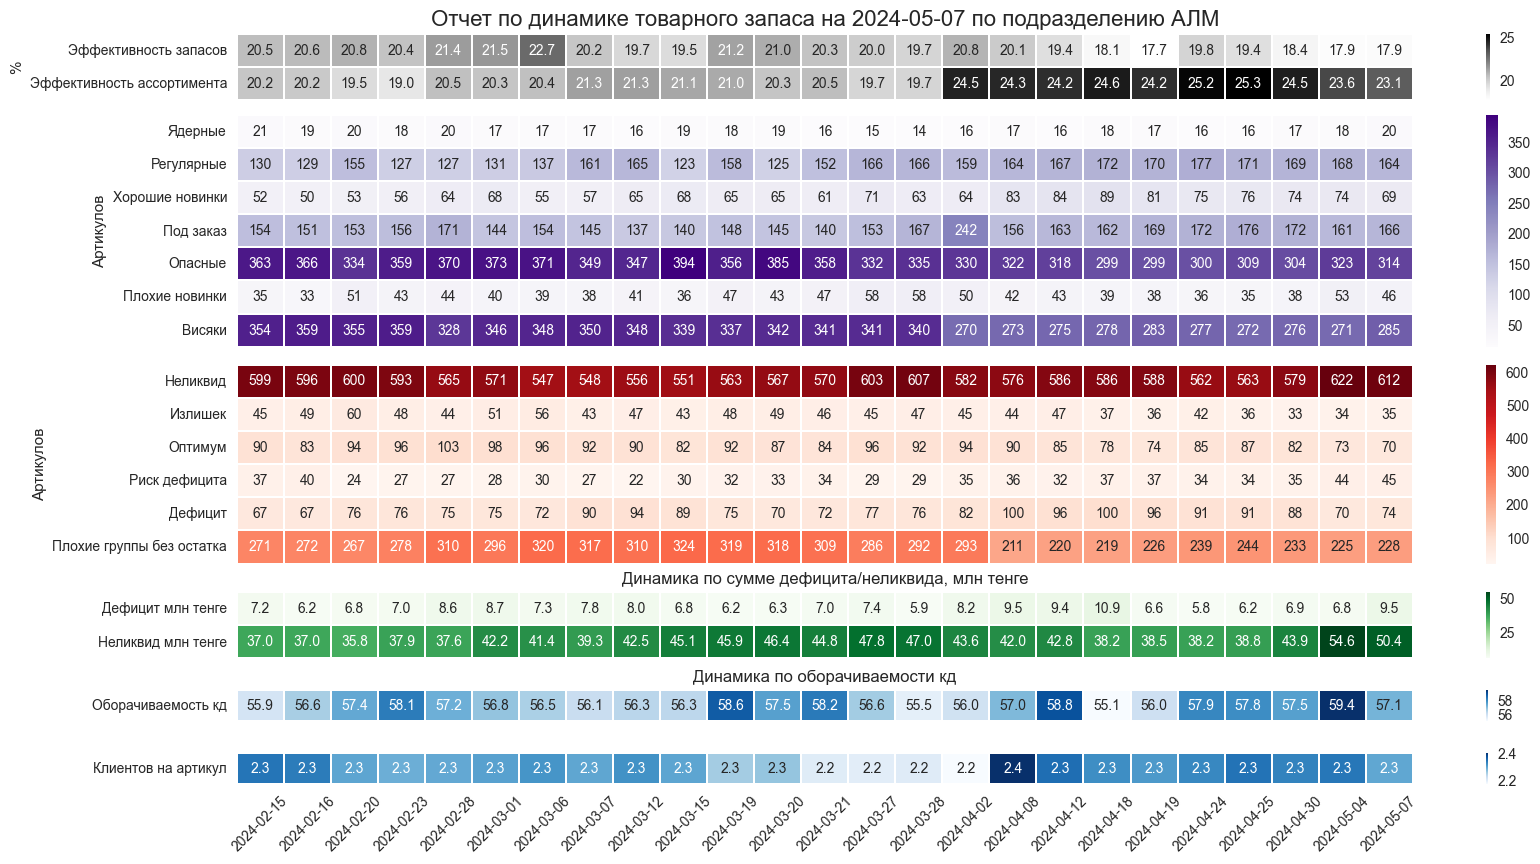

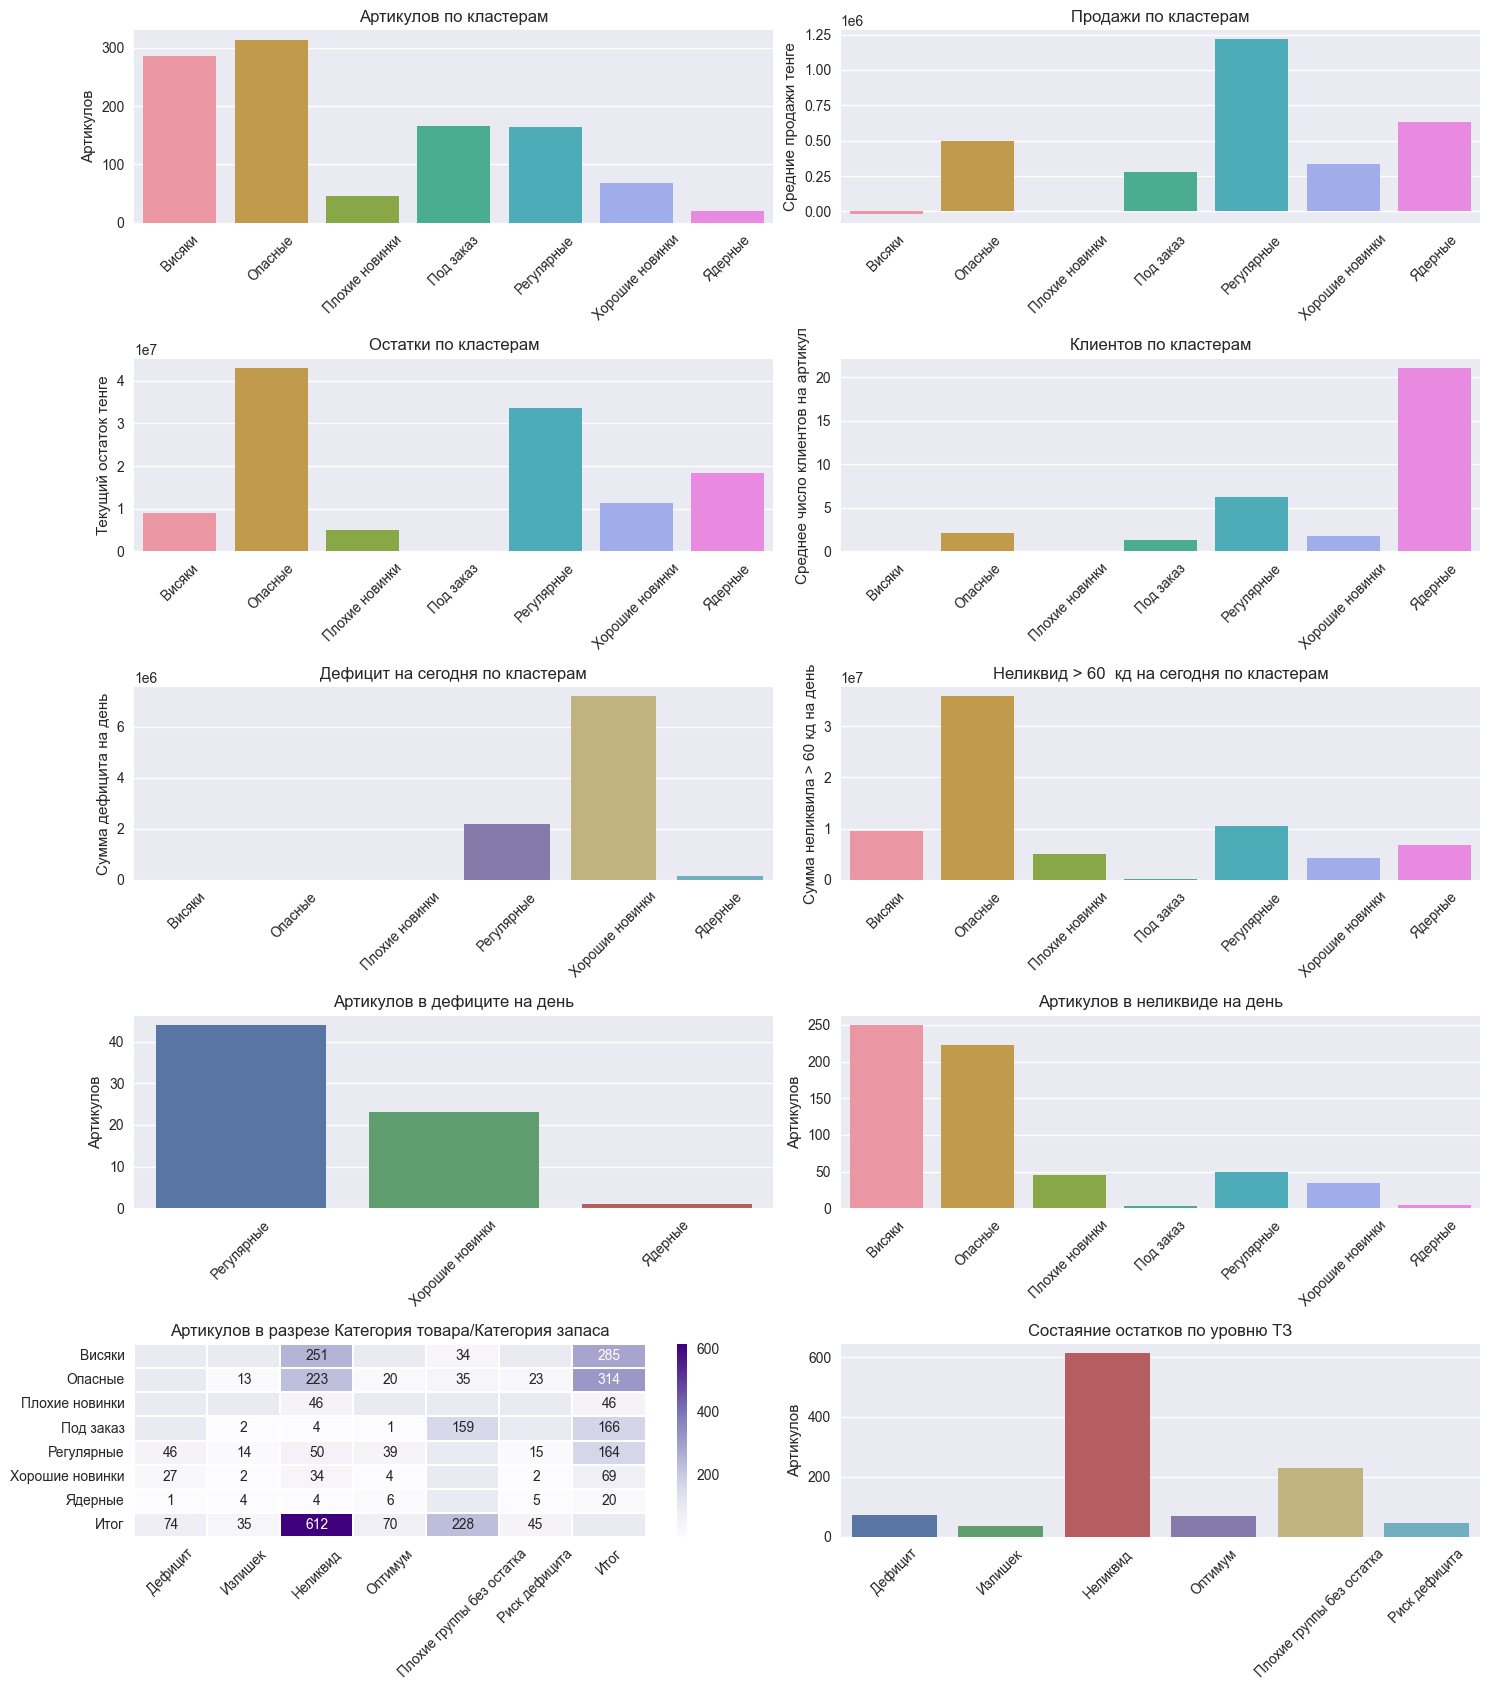

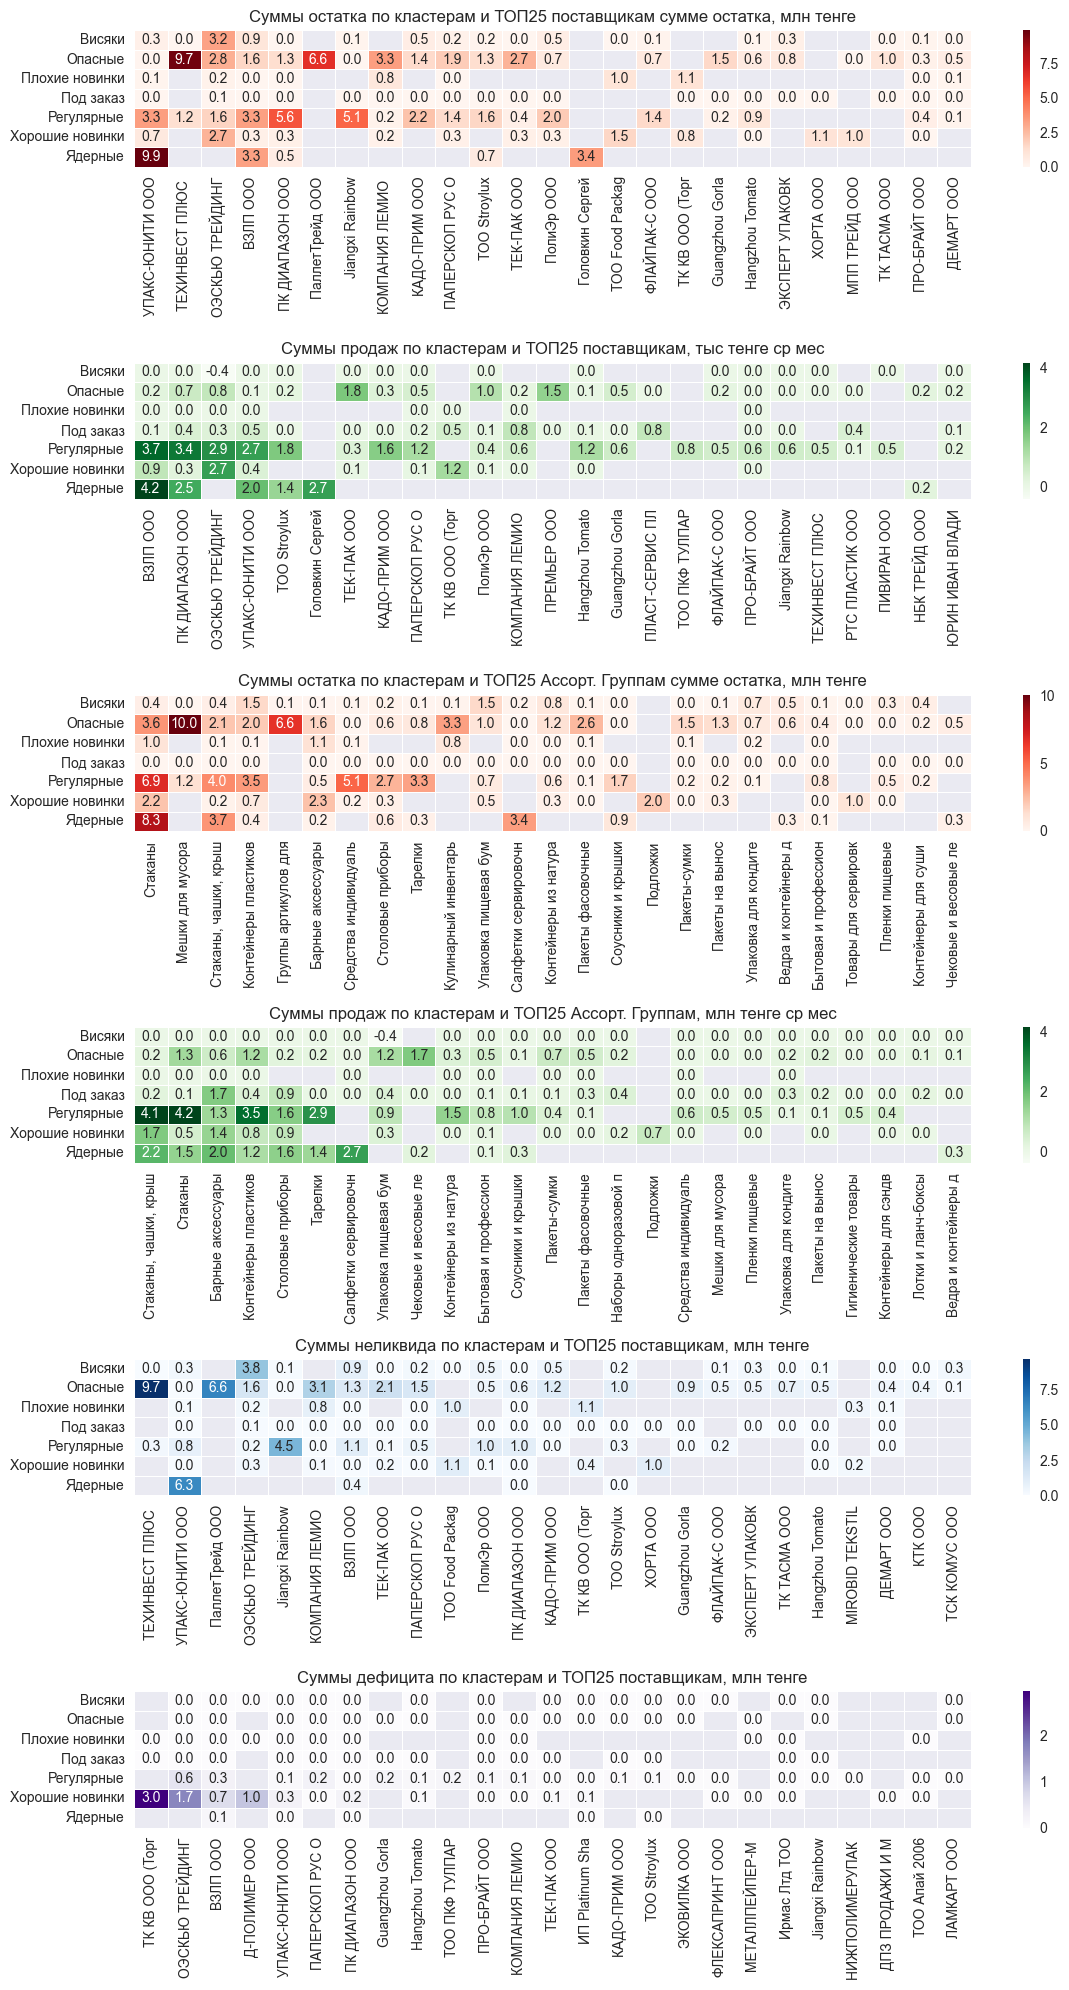

In [178]:

#Визуализация таблицы общих показателей в динамике
fig = plt.figure(figsize=[15,9])
ax0 = fig.add_axes([0.12,   0.86,  0.98, 0.105*0.7])
ax1 = fig.add_axes([0.12,   0.586,  0.98, 0.368*0.7])
ax2 = fig.add_axes([0.12, 0.345, 0.98, 0.316*0.7])
ax3 = fig.add_axes([0.12, 0.24, 0.98, 0.105*0.7])
ax4 = fig.add_axes([0.12, 0.17, 0.98, 0.05*0.7])
ax5 = fig.add_axes([0.12, 0.1, 0.98, 0.05*0.7])

if table4.shape[0] > 25:
    table4 = table4.iloc[-25:,:]

cat_list = ['Эффективность запасов','Эффективность ассортимента']
heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.1f', cmap='Greys', linewidths=0.1, ax=ax0) 
heat.set_title('Отчет по динамике товарного запаса на ' +str(Stocks['ДАТА'].dt.date.max()) + ' по подразделению '+str(region),fontdict={'size': 16})
heat.axes.set_ylabel('%')
heat.axes.set_xlabel('')
heat.xaxis.set_ticklabels('')

cat_list = ['Ядерные','Регулярные','Хорошие новинки','Под заказ','Опасные','Плохие новинки','Висяки']
heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.0f', cmap='Purples', linewidths=0.1, ax=ax1) 
#heat.set_title('Отчет по динамике товарного запаса на ' +str(Stocks['ДАТА'].dt.date.max()) + ' по подразделению '+str(region),fontdict={'size': 16})
heat.axes.set_ylabel('Артикулов')
heat.axes.set_xlabel('')
heat.xaxis.set_ticklabels('')


cat_list = ['Неликвид','Излишек','Оптимум','Риск дефицита','Дефицит','Плохие группы без остатка']

heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.0f', cmap='Reds', linewidths=0.1, ax=ax2) 
#heat.set_title('Динамика по типам остатка')
heat.axes.set_ylabel('Артикулов')
heat.axes.set_xlabel('')
heat.xaxis.set_ticklabels('')

cat_list = ['Дефицит млн тенге','Неликвид млн тенге']

heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.1f', cmap='Greens', linewidths=0.1, ax=ax3) 
heat.set_title('Динамика по сумме дефицита/неликвида, млн тенге')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')
heat.xaxis.set_ticklabels('')

cat_list = ['Оборачиваемость кд']

heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.1f', cmap='Blues', linewidths=0.1, ax=ax4) 
heat.set_title('Динамика по оборачиваемости кд')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')
heat.yaxis.set_tick_params(rotation=0)
heat.xaxis.set_ticklabels('')

cat_list = ['Клиентов на артикул']

heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.1f', cmap='Blues', linewidths=0.1, ax=ax5) 
#heat.set_title('Число клиентов на артикул')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')
heat.yaxis.set_tick_params(rotation=0)
heat.xaxis.set_tick_params(rotation=45)


plt.tight_layout()
fig.savefig('output\Динамика '+str(region)+' '+str(Stocks['ДАТА'].dt.date.max())+'.png')
#Барплоты текущей ситуации по категориям

fig, axes = plt.subplots(5,2,figsize=[15,17])

table3 = piv_nom.groupby('cluster_name')['sales_mean_$'].sum()
bar1 = sns.barplot( x=table3.index, y=table3.values, ax=axes[0][1])
bar1.axes.set_ylabel('Средние продажи тенге')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Продажи по кластерам')


table3 = piv_nom.groupby('cluster_name')['АРТИКУЛ'].nunique()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[0][0])
bar1.axes.set_ylabel('Артикулов')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Артикулов по кластерам')

table3 = piv_nom.groupby('cluster_name')['curr_stock_$'].sum()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[1][0])
bar1.axes.set_ylabel('Текущий остаток тенге')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Остатки по кластерам')

table3 = piv_nom.groupby('cluster_name')['КЛИЕНТОВ'].mean()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[1][1])
bar1.axes.set_ylabel('Среднее число клиентов на артикул')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Клиентов по кластерам')

table3 = piv_nom[piv_nom['cluster_name']!='Под заказ'].groupby('cluster_name')['curr_deficit_$'].sum()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[2][0])
bar1.axes.set_ylabel('Сумма дефицита на день')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Дефицит на сегодня по кластерам')

table3 = piv_nom.groupby('cluster_name')['curr_overstok_$'].sum()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[2][1])
bar1.axes.set_ylabel('Сумма неликвила > 60 кд на день')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Неликвид > 60  кд на сегодня по кластерам')

table3 = piv_nom[(piv_nom['curr_deficit_$'] > 0) & (piv_nom['cluster_name'] != 'Под заказ')].groupby('cluster_name')['АРТИКУЛ'].nunique()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[3][0])
bar1.axes.set_ylabel('Артикулов')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Артикулов в дефиците на день')

table3 = piv_nom[piv_nom['curr_overstok_$'] > 0].groupby('cluster_name')['АРТИКУЛ'].nunique()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[3][1])
bar1.axes.set_ylabel('Артикулов')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Артикулов в неликвиде на день')


table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='stock_zone', values='АРТИКУЛ', aggfunc='nunique')
row_sum = table3.sum()
table3 = table3.T
col_sum = table3.sum()
table3 = pd.concat([table3, row_sum], axis=1)

table3 = table3.T
table3 = pd.concat([table3, col_sum], axis=1)
table3 = table3.rename({0:'Итог'}, axis=1)
table3 = table3.rename({0:'Итог'}, axis=0)
table3
heat = sns.heatmap(table3, annot=True, fmt='.0f', cmap='Purples', linewidths=0.1, ax=axes[4][0]) 
heat.set_title('Артикулов в разрезе Категория товара/Категория запаса')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')
heat.xaxis.set_tick_params(rotation=45)


table3 = table3.drop('Итог', axis=1).drop('Итог', axis=0).sum()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[4][1])
bar1.axes.set_ylabel('Артикулов')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Состаяние остатков по уровню ТЗ')

#Тепловые карты поставщик/АГ
plt.tight_layout()
fig.savefig('output\Параметры по категориям '+str(region)+' '+str(Stocks['ДАТА'].dt.date.max())+'.png')

fig, axes = plt.subplots(6,1,figsize=[12,20])

max_stock_suppliers = piv_nom.groupby('ПОСТАВЩИК')['curr_stock_$'].sum().sort_values(ascending=False).iloc[:25]
table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='ПОСТАВЩИК', values='curr_stock_$', aggfunc='sum')
table3 = table3 /1000000

heat = sns.heatmap(table3[list(max_stock_suppliers.index)],  cmap='Reds',linewidth=.5, annot=True, fmt='.1f', ax=axes[0])
heat.set_title('Суммы остатка по кластерам и ТОП25 поставщикам сумме остатка, млн тенге')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')

max_stock_suppliers = piv_nom.groupby('ПОСТАВЩИК')['sales_mean_$'].sum().sort_values(ascending=False).iloc[:25]
table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='ПОСТАВЩИК', values='sales_mean_$', aggfunc='sum')
table3 = table3 /1000000 * 21

heat = sns.heatmap(table3[list(max_stock_suppliers.index)],  cmap='Greens',linewidth=.5, annot=True, fmt='.1f', ax=axes[1])
heat.set_title('Суммы продаж по кластерам и ТОП25 поставщикам, тыс тенге ср мес')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')


max_stock_suppliers = piv_nom.groupby('АГ')['curr_stock_$'].sum().sort_values(ascending=False).iloc[:25]
table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='АГ', values='curr_stock_$', aggfunc='sum')
table3 = table3 /1000000

heat = sns.heatmap(table3[list(max_stock_suppliers.index)],  cmap='Reds',linewidth=.5, annot=True, fmt='.1f', ax=axes[2])
heat.set_title('Суммы остатка по кластерам и ТОП25 Ассорт. Группам сумме остатка, млн тенге')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')

max_stock_suppliers = piv_nom.groupby('АГ')['sales_mean_$'].sum().sort_values(ascending=False).iloc[:25]
table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='АГ', values='sales_mean_$', aggfunc='sum')
table3 = table3 /1000000 * 21

heat = sns.heatmap(table3[list(max_stock_suppliers.index)],  cmap='Greens',linewidth=.5, annot=True, fmt='.1f', ax=axes[3])
heat.set_title('Суммы продаж по кластерам и ТОП25 Ассорт. Группам, млн тенге ср мес')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')

max_stock_suppliers = piv_nom.groupby('ПОСТАВЩИК')['curr_overstok_$'].sum().sort_values(ascending=False).iloc[:25]
table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='ПОСТАВЩИК', values='curr_overstok_$', aggfunc='sum')
table3 = table3 /1000000

heat = sns.heatmap(table3[list(max_stock_suppliers.index)],  cmap='Blues',linewidth=.5, annot=True, fmt='.1f', ax=axes[4])
heat.set_title('Суммы неликвида по кластерам и ТОП25 поставщикам, млн тенге')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')

max_stock_suppliers = piv_nom.groupby('ПОСТАВЩИК')['curr_deficit_$'].sum().sort_values(ascending=False).iloc[:25]
table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='ПОСТАВЩИК', values='curr_deficit_$', aggfunc='sum')
table3 = table3 /1000000

heat = sns.heatmap(table3[list(max_stock_suppliers.index)],  cmap="Purples",linewidth=.5, annot=True, fmt='.1f', ax=axes[5])
heat.set_title('Суммы дефицита по кластерам и ТОП25 поставщикам, млн тенге')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')


plt.tight_layout()
fig.savefig('output\Аналитика поставщик-АГ '+str(region)+' '+str(Stocks['ДАТА'].dt.date.max())+'.png')

#Наполненность ассортиментной матрицы
#table3 = pd.pivot_table(data=piv_nom, index='АГ', columns='cluster_name', values='АРТИКУЛ', aggfunc='nunique')
#max_stock_suppliers = piv_nom.groupby('АГ')['sales_mean_$'].sum().sort_values(ascending=False)
#fig, axes = plt.subplots(1,1,figsize=[6,10])
#table3 = table3.T[list(max_stock_suppliers.index)]
#SUM_1 = table3.sum()
#table3 = table3.T
#table3['Итог'] = SUM_1
#heat = sns.heatmap(table3[['Ядерные','Регулярные','Опасные','Хорошие новинки','Плохие новинки','Висяки','Под заказ','Итог']],  cmap="Greys",linewidth=.5, annot=True, fmt='.0f', ax=axes)
#heat.set_title('Наполненность ассортментных групп')
#heat.axes.set_ylabel('')
#heat.axes.set_xlabel('')

#plt.tight_layout()
#fig.savefig('output\Наполненность ассортментных групп '+str(region)+' '+str(Stocks['ДАТА'].dt.date.max())+'.png')



Расчет заказа

In [179]:
#suppliers = pd.read_excel('data\ПАРАМЕТРЫ ПОСТАВЩИКОВ.xlsx')

#suppliers['ПОСТАВЩИК'] = suppliers['ПОСТАВЩИК'].apply(lambda x: x[:15])

suppliers = pd.read_excel('data\ПАРАМЕТРЫ ПОСТАВЩИКОВ 2.xlsx')
suppliers = suppliers[suppliers['ФИЛИАЛ'] == region].drop('ФИЛИАЛ', axis=1)
suppliers['ПОСТАВЩИК'] = suppliers['ПОСТАВЩИК'].apply(lambda x: x[:15])

In [180]:

def count_orders(art):
    #Собираем данные по артикулу по плечу поставки и регулярности прихода, по умолчанию 10 и 8
    regularity_days = suppliers[suppliers['ПОСТАВЩИК'] == 'По умолчанию']['РЕГУЛЯРНОСТЬ ДНИ'].iloc[0]
    transport_days = suppliers[suppliers['ПОСТАВЩИК'] == 'По умолчанию']['ПЛЕЧО ДНИ'].iloc[0]
    
    supplier = piv_nom[piv_nom['АРТИКУЛ'] == art]['ПОСТАВЩИК'].iloc[0]
    
    if supplier in list(suppliers['ПОСТАВЩИК'].values):
        regularity_days = suppliers[suppliers['ПОСТАВЩИК']== supplier]['РЕГУЛЯРНОСТЬ ДНИ'].iloc[0]
        transport_days = suppliers[suppliers['ПОСТАВЩИК']== supplier]['ПЛЕЧО ДНИ'].iloc[0] 
    #Тут нужно собрать данные по клиентам и менеджерам

    
    #Расчитаем параметры
    curr_stock = piv_nom[piv_nom['АРТИКУЛ'] == art]['curr_stock'].iloc[0]
    risk_zone_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['risk_zone_level'].iloc[0]
    mean_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['sales_mean'].iloc[0]
    stock_on_income = max([curr_stock - mean_level*transport_days,0])
    sales_dynamics = piv_nom[piv_nom['АРТИКУЛ'] == art]['sales_sym'].iloc[0]
    aim_stock = (risk_zone_level + mean_level*regularity_days)*(1+sales_dynamics)
    upcomming = piv_nom[piv_nom['АРТИКУЛ'] == art]['В пути'].iloc[0]
    #if (aim_stock < piv_nom[piv_nom['АРТИКУЛ'] == art]['Кор'].iloc[0]) and (piv_nom[piv_nom['АРТИКУЛ'] == art]['СТАТУС'].iloc[0] == 'Матричная'):
    #    aim_stock = piv_nom[piv_nom['АРТИКУЛ'] == art]['Кор'].iloc[0]
    
    order = aim_stock - stock_on_income - upcomming
    part_of_max_client = piv_nom[piv_nom['АРТИКУЛ'] == art]['ДОЛЯ МАКС КЛИЕНТА'].iloc[0]
    
    
    #Расчитаем заказ в зависимости от группы
    if piv_nom[piv_nom['АРТИКУЛ'] == art]['cluster_name'].iloc[0] in ['Ядерные','Регулярные','Хорошие новинки']:
        max_client = ''
        max_manager = ''
        if part_of_max_client > 0.8:
            max_client = Sales[Sales['АРТИКУЛ'] == art].groupby('КЛИЕНТ')['ПРОДАЖА ШТ'].sum().sort_values(ascending=False).index[0]
            max_manager = Sales[Sales['КЛИЕНТ'] == max_client]['МЕНЕДЖЕР'].iloc[0]
            max_manager = ' менеджера '+ str(max_manager)
            max_client = ' если сохраняются заказы клиента ' + str(max_client) + max_manager
            
        if piv_nom[piv_nom['АРТИКУЛ'] == art]['cluster_name'].iloc[0] == 'Хорошие новинки':
            max_client = ' Новинка! ' + max_client
             
        if (curr_stock>0) and (order/curr_stock<0.2):
            order = 0   
            
        if (curr_stock < piv_nom[piv_nom['АРТИКУЛ'] == art]['Кор'].iloc[0]) and (order == 0) and (upcomming==0) and (piv_nom[piv_nom['АРТИКУЛ'] == art]['СТАТУС'].iloc[0] == 'Матричная') and (piv_nom[piv_nom['АРТИКУЛ'] == art]['curr_overstok'].iloc[0] == 0):  #
            order = piv_nom[piv_nom['АРТИКУЛ'] == art]['Кор'].iloc[0]                          #
        
        return max([order,0]), 'Верить автозаказу' + max_client
    
    if piv_nom[piv_nom['АРТИКУЛ'] == art]['cluster_name'].iloc[0] == 'Опасные':
        
        d = dict()
        man_list = list(Sales[Sales['АРТИКУЛ'] == art].groupby('МЕНЕДЖЕР')['ПРОДАЖА ШТ'].sum().sort_values(ascending=False).index)
        for man in man_list:
            dff = Sales[Sales['АРТИКУЛ'] == art].groupby(['МЕНЕДЖЕР','КЛИЕНТ'])['ПРОДАЖА ШТ'].sum().reset_index().sort_values(by='ПРОДАЖА ШТ',ascending=False)
            dff = dff[dff['МЕНЕДЖЕР']== man]['КЛИЕНТ'].unique()
            d[man] = list(dff)
        
        order = 0
        if (curr_stock < piv_nom[piv_nom['АРТИКУЛ'] == art]['Кор'].iloc[0]) and (order == 0) and (upcomming==0) and (piv_nom[piv_nom['АРТИКУЛ'] == art]['СТАТУС'].iloc[0] == 'Матричная') and (piv_nom[piv_nom['АРТИКУЛ'] == art]['curr_overstok'].iloc[0] == 0):  #
            order = piv_nom[piv_nom['АРТИКУЛ'] == art]['Кор'].iloc[0]         
        
        return max([order,0]), 'Опасная позиция, проверить!: ' + str(d)
    
    if piv_nom[piv_nom['АРТИКУЛ'] == art]['cluster_name'].iloc[0] in ['Висяки','Плохие новинки']:
        return 0, '---'
    else:
        
        d = dict()
        man_list = list(Sales[Sales['АРТИКУЛ'] == art].groupby('МЕНЕДЖЕР')['ПРОДАЖА ШТ'].sum().sort_values(ascending=False).index)
        for man in man_list:
            dff = Sales[Sales['АРТИКУЛ'] == art].groupby(['МЕНЕДЖЕР','КЛИЕНТ'])['ПРОДАЖА ШТ'].sum().reset_index().sort_values(by='ПРОДАЖА ШТ',ascending=False)
            dff = dff[dff['МЕНЕДЖЕР']== man]['КЛИЕНТ'].unique()
            d[man] = list(dff)
        
        order = 0
        
        if (curr_stock < piv_nom[piv_nom['АРТИКУЛ'] == art]['Кор'].iloc[0]) and (order == 0)and (upcomming==0) and (piv_nom[piv_nom['АРТИКУЛ'] == art]['СТАТУС'].iloc[0] == 'Матричная') and (piv_nom[piv_nom['АРТИКУЛ'] == art]['curr_overstok'].iloc[0] == 0):  #
            order = piv_nom[piv_nom['АРТИКУЛ'] == art]['Кор'].iloc[0]     
             
        return order, 'Проверить заказы: ' + str(d)

In [181]:
piv_nom['order'] = piv_nom['АРТИКУЛ'].apply(lambda x: count_orders(x)[0])
piv_nom['order_comment'] = piv_nom['АРТИКУЛ'].apply(lambda x: count_orders(x)[1])
piv_nom['order_$'] = piv_nom['order'] * piv_nom['ЦЕНА']

In [182]:
#mask = (piv_nom['cluster_name'] == 'Под заказ') | (piv_nom['order'] > 0)
piv_nom[['АРТИКУЛ','ЕД ИЗМ','ДУБЛИКАТЫ', 'ТОВАР', 'ПОСТАВЩИК', 'СТАТУС','Кор','Объем',
               'АКТИВНОСТЬ','cluster_name','КЛИЕНТОВ','ДОЛЯ МАКС КЛИЕНТА',
               'sales_sym','В пути','order','order_$', 'order_comment','curr_overstok']].sort_values(by='order_$', ascending=False).to_excel('output\Потребность '+ str(region) +' '+str(Stocks['ДАТА'].dt.date.max())+'.xlsx')

Визуализация по конкретному артикулу

In [183]:
piv_nom.to_excel('Стат параметры '+ str(region) +'.xlsx')
table2.to_excel('Продажи '+ str(region) +'.xlsx')
table.to_excel('Остатки '+ str(region) +'.xlsx')

In [184]:
piv_nom[piv_nom['cluster_name'] == 'Висяки']['АРТИКУЛ'].values

array([102136, 102138, 102071, 111379, 111365, 111326, 110268, 100399,
       100340, 103014, 100941, 101475, 102078, 103004, 102662, 321902,
       103586, 102672, 105960, 102137, 108041, 110076, 103584, 100688,
       102081, 102096, 101835, 110953, 111381, 110862, 111382, 111327,
       110722, 102082, 109994, 100047, 107756, 111233, 481046, 102411,
       109501, 102733, 103600, 100024, 102714, 103001, 250043, 100353,
       111320, 110142, 109513, 111376, 101821, 106588, 111288, 101822,
       100668, 111289, 100749, 104004, 260054, 101616, 101229, 110456,
       107810, 111242, 101569, 102759, 100300, 104093, 361618, 100281,
       103089, 111385, 106040, 102036, 101470, 100290, 107817, 107824,
       153500, 154718, 303249, 105135, 256027, 101460, 106926, 106939,
       155870, 111055, 105450, 104023, 111223, 110477, 252025, 102340,
       107918, 101611, 107153, 100755, 111345, 103987, 103990, 101296,
       111383, 111340, 101645, 307971, 158190, 591830, 111378, 111384,
      

Кластер:  Ядерные
Регулярность дни:  5
Плечо дни:  3
Остаток к приходу:  5035.0
Середина оптимального остатка:  97238.0
Зона риска:  25800.0
Cредние продажи в день:  3175.0
Целевой остаток:  51715.0
Заказ:  46680.0
Дубликаты:  
КЛИЕНТОВ:  27
Динамика продаж:  0.24


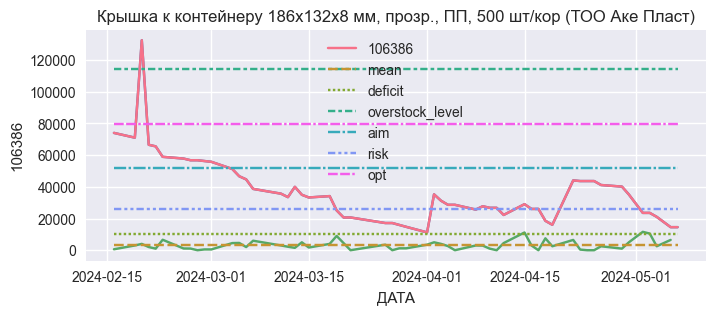

In [185]:
art =106386

regularity_days = suppliers[suppliers['ПОСТАВЩИК'] == 'По умолчанию']['РЕГУЛЯРНОСТЬ ДНИ'].iloc[0]
transport_days = suppliers[suppliers['ПОСТАВЩИК'] == 'По умолчанию']['ПЛЕЧО ДНИ'].iloc[0]

if piv_nom[piv_nom['АРТИКУЛ'] == art].shape[0]>0:
    supplier = piv_nom[piv_nom['АРТИКУЛ'] == art]['ПОСТАВЩИК'].iloc[0]
    
    if supplier in list(suppliers['ПОСТАВЩИК'].values):
        regularity_days = suppliers[suppliers['ПОСТАВЩИК']== supplier]['РЕГУЛЯРНОСТЬ ДНИ'].iloc[0]
        transport_days = suppliers[suppliers['ПОСТАВЩИК']== supplier]['ПЛЕЧО ДНИ'].iloc[0] 

if piv_nom[piv_nom['АРТИКУЛ'] == art].shape[0]>0:
    art_name = piv_nom[piv_nom['АРТИКУЛ'] == art]['ТОВАР'].iloc[0]
    curr_stock = piv_nom[piv_nom['АРТИКУЛ'] == art]['curr_stock'].iloc[0]
    deficit_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['deficit_level'].iloc[0]
    risk_zone_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['risk_zone_level'].iloc[0]
    optimum_zone_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['optimum_zone_level'].iloc[0]
    overstock_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['overstock_level'].iloc[0]
    mean_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['sales_mean'].iloc[0]
    sales_dynamics = piv_nom[piv_nom['АРТИКУЛ'] == art]['sales_sym'].iloc[0]
    print('Кластер: ',piv_nom[piv_nom['АРТИКУЛ']==art]['cluster_name'].iloc[0])
    print('Регулярность дни: ',regularity_days)
    print('Плечо дни: ',transport_days)

    stock_on_income = max([curr_stock - mean_level*transport_days,0])
    print('Остаток к приходу: ',stock_on_income)
    print('Середина оптимального остатка: ',(optimum_zone_level + (overstock_level-optimum_zone_level)/2).round(0))
    print('Зона риска: ',risk_zone_level.round(0))
    print('Cредние продажи в день: ',mean_level.round(0))

    aim_stock = (risk_zone_level + mean_level*regularity_days)*(1+sales_dynamics)
    print('Целевой остаток: ',aim_stock.round(0))
    order = piv_nom[piv_nom['АРТИКУЛ'] == art]['order'].iloc[0]
    print('Заказ: ',order.round(0))
    print('Дубликаты: ',piv_nom[piv_nom['АРТИКУЛ']==art]['ДУБЛИКАТЫ'].iloc[0])
    print('КЛИЕНТОВ: ',piv_nom[piv_nom['АРТИКУЛ']==art]['КЛИЕНТОВ'].iloc[0])
    print('Динамика продаж: ',piv_nom[piv_nom['АРТИКУЛ'] == art]['sales_sym'].iloc[0].round(2))


    fig, ax = plt.subplots(1,1, figsize = [8,3])
    sns.lineplot(table[art].T, ax=ax)

    if art in list(table2.columns):
        sns.lineplot(table2[art].T, ax=ax)
    line = pd.DataFrame(table[art].T.copy())

    if art in list(table2.columns):
        std_level = (mean_level + 3*table2.describe().T.loc[art]['std'])
    else:
        std_level = 0

    line['mean'] = mean_level
    line['deficit'] = deficit_level
    line['overstock_level'] = piv_nom[piv_nom['АРТИКУЛ']== art]['overstock_level'].iloc[0]
    line['aim'] = aim_stock
    line['risk'] = risk_zone_level
    line['opt'] = optimum_zone_level
    ax.set_title(art_name)

    sns.lineplot(line, ax=ax)

    

else:
    print('Артикул в регионе без движения и остатков')

# ASIA SALES

In [186]:
#Sales_clients = Sales.copy()

#Sales_clients = pd.merge(left=Sales_clients, right=piv_nom[['АРТИКУЛ','ЦЕНА']], on='АРТИКУЛ', how='left')
#Sales_clients['ПРОДАЖА_$'] = Sales_clients['ПРОДАЖА ШТ']*Sales_clients['ЦЕНА']
#Sales_clients.head()

In [187]:
#client_sales_table = pd.pivot_table(data=Sales_clients, index='ДАТА', columns='КЛИЕНТ', values='ПРОДАЖА_$')
#client_sales_table = client_sales_table.fillna(0)
#client_sales_table.head()

In [188]:
#piv_cl = pd.pivot_table(data=Sales_clients[['КЛИЕНТ','ПРОДАЖА_$']], index='КЛИЕНТ',aggfunc='sum').reset_index()
#piv_cl

In [189]:
#piv_cl['first_date'] = piv_cl['КЛИЕНТ'].apply(lambda x: client_sales_table[client_sales_table[x] > 0][x].index[0])
#piv_cl['last_date'] = piv_cl['КЛИЕНТ'].apply(lambda x: client_sales_table[client_sales_table[x] > 0][x].index[-1])
#piv_cl['ltv'] = piv_cl['last_date'] - piv_cl['first_date']
#piv_cl['ltv'] = piv_cl['ltv'].apply(lambda x: x.days)

#max_date = Sales_clients['ДАТА'].max()
#piv_cl['recency'] = max_date - piv_cl['last_date']
#piv_cl['recency'] = piv_cl['recency'].apply(lambda x: x.days)

#piv_cl['recency_first'] = piv_cl['recency'] + piv_cl['ltv']


#def set_sales_sym_for_clients(client):
#    start_date = piv_cl[piv_cl['КЛИЕНТ'] == client]['first_date'].iloc[0]
#    sales_by_client = client_sales_table[client].reset_index()
#    sales_by_client = sales_by_client[sales_by_client['ДАТА']>=start_date][client].values
    
#    min_val = sales_by_client.min()
#    max_val = sales_by_client.max()
#    v = np.linspace(min_val,max_val,len(sales_by_client))
#    w = sales_by_client
#    v = v - v.mean()
#    v = v / np.linalg.norm(v)
#    w = w - w.mean()
#    if np.linalg.norm(w)<0.0001:
#        return 0
#    w = w /np.linalg.norm(w)
#    return v@w
    
#piv_cl['sales_dynamics'] =  piv_cl['КЛИЕНТ'].apply(set_sales_sym_for_clients)
#piv_cl['regularuty'] = piv_cl['КЛИЕНТ'].apply(lambda x: Sales_clients[Sales_clients['КЛИЕНТ'] == x]['ДАТА'].nunique())
#piv_cl['week_regularuty'] = piv_cl['КЛИЕНТ'].apply(lambda x: Sales_clients[Sales_clients['КЛИЕНТ'] == x]['НЕДЕЛЯ'].nunique())
#piv_cl['SKU_count'] = piv_cl['КЛИЕНТ'].apply(lambda x: Sales_clients[Sales_clients['КЛИЕНТ'] == x]['АРТИКУЛ'].nunique())


#client_sku_table = pd.pivot_table(data=Sales_clients, index='ДАТА', columns='КЛИЕНТ', values='АРТИКУЛ', aggfunc='nunique')
#client_sku_table = client_sku_table.fillna(0)



#def set_sku_sym_for_clients(client):
#
#    sku_by_client = client_sku_table[client_sku_table[client]>0][client].values
    
#    min_val = sku_by_client.min()
#    max_val = sku_by_client.max()
#    v = np.linspace(min_val,max_val,len(sku_by_client))
#    w = sku_by_client
#    v = v - v.mean()
#    v = v / np.linalg.norm(v)
#    w = w - w.mean()
#    if np.linalg.norm(w)<0.0001:
#        return 0
#    w = w /np.linalg.norm(w)
#    return v@w

#piv_cl['sku_dynamics'] =  piv_cl['КЛИЕНТ'].apply(set_sku_sym_for_clients)


In [190]:
#client_features = ['recency','regularuty','SKU_count','ПРОДАЖА_$']

In [191]:
#clust_data = piv_cl[client_features]
##sns.heatmap(clust_data.corr(), annot=True, fmt='.2f')

In [192]:
#scaler = MinMaxScaler()
#clust_data_trasformed = scaler.fit_transform(clust_data)

In [193]:
#from sklearn.cluster import AgglomerativeClustering

#params = list()
#for i in range(2,8):
#    agc = AgglomerativeClustering(n_clusters=i)
#    clusters = agc.fit_predict(clust_data_trasformed)
#    params.append([i,silhouette_score(clust_data_trasformed,clusters)])
    
#params = pd.DataFrame(params, columns=['K','silhouette'])
#params.sort_values('silhouette', ascending=False).iloc[:5]

In [194]:
#fig = sns.lineplot(data=params, x='K', y='silhouette')
#fig.set_title('График коэф-та силуэта для KMeans кластеризации')
#fig.set_xlabel('Число кластеров')

In [195]:
#best_model = KMeans(random_state=100, n_clusters=4)
#best_model.fit(clust_data_trasformed)
#labels = best_model.labels_
#pd.Series(best_model.labels_).value_counts()

In [196]:
#piv_cl_1 = piv_cl[ client_features ]

#scaler = MinMaxScaler()
#piv_cl_1 = scaler.fit_transform(piv_cl_1)
#piv_cl_1 = pd.DataFrame(piv_cl_1, columns=client_features )
#piv_cl_1['cluster'] = labels

#cluster_definition = piv_cl_1.groupby('cluster').mean()
#fig = sns.heatmap(cluster_definition, annot=True, fmt='.2f')
#fig.set_title('Тепловая карта центроидов кластров')

In [197]:
#piv_cl['cluster'] =  labels

In [198]:

#cluster = list(piv_cl[piv_cl['cluster']==2]['КЛИЕНТ'])


#fig, axes = plt.subplots(len(cluster)//6+2,6, figsize = [20,len(cluster)//6*2+3])
#for i,art in enumerate(cluster):
#    if art in list(client_sales_table.columns):
#        sns.lineplot(client_sales_table[art].T, ax=axes[i//6][i%6])
#        axes[i//6][i%6].set_xlabel(' ')
#        axes[i//6][i%6].set_ylabel(' ')
#        axes[i//6][i%6].set_title(str(art)+' '+str(piv_cl[piv_cl['КЛИЕНТ']==art]['sales_dynamics'].iloc[0].round(2))+
#                                  ' '+str(piv_cl[piv_cl['КЛИЕНТ']==art]['sku_dynamics'].iloc[0].round(2)))
     
#plt.tight_layout()